In [ ]:
import pandas as pd
import itertools
import datetime
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


In [ ]:
def load_metrics(run_dir, metrics_dir):
    """Load the training metrics from the JSON file."""
    run_metrics_path = os.path.join(metrics_dir, run_dir, 'training_metrics.json')
    
    if not os.path.isfile(run_metrics_path):
        print(f"Skipping {run_dir} because 'training_metrics.json' is missing.")
        return None
    
    with open(run_metrics_path, 'r') as f:
        metrics = json.load(f)
    
    return metrics

def load_settings(run_dir, metrics_dir):
    """Load the training settings from the JSON file."""
    run_settings_path = os.path.join(metrics_dir, run_dir, "training_settings.json")

    if not os.path.isfile(run_settings_path):
        print(f"Skipping {run_dir} because 'training_settings.json' is missing.")
        return None
        
    with open(run_settings_path, 'r') as f:
        settings = json.load(f)
    
    return settings

In [ ]:
def smooth_data(y, window_size=51, polyorder=3):
    """Smooth data using Savitzky-Golay filter."""
    if len(y) < window_size:
        return y
    return savgol_filter(y, window_size, polyorder)


In [ ]:
def extract_loss_data(metrics):
    """Extract loss data for plotting from the metrics."""
    train_metrics = metrics.get('train', [])
    test_metrics = metrics.get('test', [])
    
    train_iterations = [entry['iteration'] for entry in train_metrics]
    train_total_loss = [entry['total_loss'] for entry in train_metrics]
    test_iterations = [entry['iteration'] for entry in test_metrics]
    test_total_loss = [entry['total_loss'] for entry in test_metrics]
    
    return {
        'train_iterations': train_iterations,
        'train_total_loss': train_total_loss,
        'test_iterations': test_iterations,
        'test_total_loss': test_total_loss
    }

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def smooth_data(y, window_size=51, polyorder=3):
    """Smooth data using Savitzky-Golay filter."""
    if len(y) < window_size:
        return y
    return savgol_filter(y, window_size, polyorder)

def plot_losses_with_settings(loss_data, run_dir, y_min, y_max, settings):
    """Plot the losses with trendline and decreased opacity, and return iterations of min and best overall losses."""
    # Extract loss data
    train_iterations = loss_data['train_iterations']
    train_total_loss = loss_data['train_total_loss']
    test_iterations = loss_data['test_iterations']
    test_total_loss = loss_data['test_total_loss']
    
    # Smooth the loss data using Savitzky-Golay filter for trendline
    smoothed_train_total_loss = smooth_data(train_total_loss)
    smoothed_test_total_loss = smooth_data(test_total_loss)

    # Set plot settings
    keys_to_extract = ["fill_replay_setting", "RGB_AUGMENTATION", "keypoint_approach", "cameras"]
    fill_replay = settings.get("fill_replay_setting", "N/A")
    rgb_augmentation = settings.get("RGB_AUGMENTATION", "N/A")
    keypoint_approach = settings.get("keypoint_approach", "N/A")
    cameras_count = len(settings.get("cameras", []))  # Get the number of cameras
    other_settings = {key: settings[key] for key in settings if key not in keys_to_extract}

    # Create a plot title with the extracted settings information
    title = (f'Losses for Run: {run_dir}\n'
             f'Fill Replay: {fill_replay}, RGB Augmentation: {rgb_augmentation}, '
             f'Keypoint Approach: {keypoint_approach}, Cameras: {cameras_count}, '
             f'Others: {other_settings}')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(title)
    
    # Plot Total Loss with lower opacity
    ax.plot(train_iterations, train_total_loss, label='Train Total Loss', color='blue', alpha=0.3)
    ax.plot(test_iterations, test_total_loss, label='Test Total Loss', color='red', alpha=0.3)

    # Plot smoothed (trendline) Total Loss
    ax.plot(train_iterations, smoothed_train_total_loss, label='Smoothed Train Total Loss', color='blue', linestyle='--', alpha=0.8)
    ax.plot(test_iterations, smoothed_test_total_loss, label='Smoothed Test Total Loss', color='red', linestyle='--', alpha=0.8)

    # Highlight the minimum loss for train and test using vertical lines (full opacity)
    min_train_loss_iter = train_iterations[np.argmin(train_total_loss)]
    min_test_loss_iter = test_iterations[np.argmin(test_total_loss)]
    
    ax.axvline(x=min_train_loss_iter, color='blue', linestyle=':', alpha=1.0)  # Full opacity for vertical line
    ax.axvline(x=min_test_loss_iter, color='red', linestyle=':', alpha=1.0)   # Full opacity for vertical line
    
    # Add a horizontal line at the minimum loss values in the legend
    min_train_loss = min(train_total_loss)
    min_test_loss = min(test_total_loss)
    
    # Find the test loss corresponding to the minimum training loss
    min_train_loss_index = np.argmin(train_total_loss)
    corresponding_test_loss = test_total_loss[min_train_loss_index]
    
    # Find the training loss corresponding to the minimum test loss
    min_test_loss_index = np.argmin(test_total_loss)
    corresponding_train_loss = train_total_loss[min_test_loss_index]
    
    # Adding the minimum loss points to the legend with counterpart losses
    ax.plot([], [], color='blue', linestyle=':', 
            label=f'Min. Train Loss: {min_train_loss:.4f} - Test Loss: {corresponding_test_loss:.4f} @ Iter {min_train_loss_iter}')
    ax.plot([], [], color='red', linestyle=':', 
            label=f'Min. Test Loss: {min_test_loss:.4f} - Train Loss: {corresponding_train_loss:.4f} @ Iter {min_test_loss_iter}')
    
    # Find the best overall loss
    best_overall_loss_iter = None
    best_overall_loss = float('inf')
    
    for i in range(1, len(train_total_loss)):
        # Consider the iteration where both train and test losses are lower than previous iterations
        if train_total_loss[i] < train_total_loss[i - 1] and test_total_loss[i] < test_total_loss[i - 1]:
            overall_loss = train_total_loss[i] + test_total_loss[i]
            if overall_loss < best_overall_loss:
                best_overall_loss = overall_loss
                best_overall_loss_iter = train_iterations[i]  # Corresponds to both training and testing iteration

    # Add the best overall loss to the plot (vertical line)
    best_overall_train_loss = None
    best_overall_test_loss = None
    if best_overall_loss_iter is not None:
        ax.axvline(x=best_overall_loss_iter, color='green', linestyle='-.', alpha=1.0)
        
        # Find corresponding losses
        best_overall_train_loss = train_total_loss[train_iterations.index(best_overall_loss_iter)]
        best_overall_test_loss = test_total_loss[test_iterations.index(best_overall_loss_iter)]

        # Add label for the best overall loss
        ax.plot([], [], color='green', linestyle='-.', 
                label=f'Best Overall Loss: Train {best_overall_train_loss:.4f} - Test {best_overall_test_loss:.4f} @ Iter {best_overall_loss_iter}')
    
    # Set y-axis limits
    ax.set_ylim(y_min, y_max)
    
    # Set axis labels and legend
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Loss')
    ax.legend(loc='upper right')
    
    # Display the plot
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    # Return the min and best overall loss information along with the iteration numbers
    return (min_train_loss, min_test_loss, min_train_loss_iter, min_test_loss_iter, best_overall_train_loss, best_overall_test_loss, best_overall_loss_iter)


In [16]:
def highlight_lowest(df):
    """Highlight the lowest values in columns for Min and Best Overall Losses."""
    is_min_train_loss = df['Min Train Loss'] == df['Min Train Loss'].min()
    is_min_test_loss = df['Min Test Loss'] == df['Min Test Loss'].min()
    is_best_overall_train = df['Best Overall Train Loss'] == df['Best Overall Train Loss'].min()
    is_best_overall_test = df['Best Overall Test Loss'] == df['Best Overall Test Loss'].min()

    # Create a new column for the styles to apply
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    
    # Highlight individual minima
    styles.loc[is_min_train_loss, 'Min Train Loss'] = 'background-color: yellow'
    styles.loc[is_min_test_loss, 'Min Test Loss'] = 'background-color: yellow'
    
    # Highlight Best Overall Train and Test Loss (separately)
    styles.loc[is_best_overall_train, 'Best Overall Train Loss'] = 'background-color: yellow'
    styles.loc[is_best_overall_test, 'Best Overall Test Loss'] = 'background-color: yellow'
    
    return styles


In [17]:
def process_runs_with_settings(metrics_dir):
    """Process all runs to generate plots with consistent scaling and sorted by date and generate a summary table including settings."""
    run_dirs = [d for d in os.listdir(metrics_dir) if os.path.isdir(os.path.join(metrics_dir, d))]
    valid_run_dirs = []
    for run_dir in run_dirs:
        try:
            datetime.datetime.strptime(run_dir, "%Y-%m-%d_%H-%M")
            valid_run_dirs.append(run_dir)
        except ValueError:
            print(f"Skipping invalid folder: {run_dir}")
            continue
    
    valid_run_dirs.sort(key=lambda x: datetime.datetime.strptime(x, "%Y-%m-%d_%H-%M"))
    results = []

    for i, run_dir in enumerate(valid_run_dirs):
        run_path = os.path.join(metrics_dir, run_dir)
        metrics = load_metrics(run_dir, metrics_dir)
        settings = load_settings(run_dir, metrics_dir)
        if metrics is None or settings is None:
            continue
        
        loss_data = extract_loss_data(metrics)
        y_min = min(loss_data['train_total_loss'] + loss_data['test_total_loss'])
        y_max = max(loss_data['train_total_loss'] + loss_data['test_total_loss'])
        
        min_train_loss, min_test_loss, min_train_iter, min_test_iter, best_overall_train_loss, best_overall_test_loss, best_overall_iter = plot_losses_with_settings(
            loss_data, run_dir, y_min, y_max, settings
        )
        
        results.append({
            'Fill Replay': settings['fill_replay_setting'],
            'Cameras': len(settings['cameras']),
            'RGB Augmentation': settings['RGB_AUGMENTATION'],
            'Keypoint Approach': settings['keypoint_approach'],
            'Run': run_dir,
            'Min Train Loss': min_train_loss,
            'Min Test Loss': min_test_loss,
            'Min Train Iteration': min_train_iter,
            'Min Test Iteration': min_test_iter,
            'Best Overall Train Loss': best_overall_train_loss,
            'Best Overall Test Loss': best_overall_test_loss,
            'Best Overall Iteration': best_overall_iter
        })
    
    results_df = pd.DataFrame(results)
    settings_columns = ['Fill Replay', 'Cameras', 'RGB Augmentation', 'Keypoint Approach']
    loss_columns = ['Run', 'Min Train Loss', 'Min Test Loss', 'Min Train Iteration', 'Min Test Iteration', 
                    'Best Overall Train Loss', 'Best Overall Test Loss', 'Best Overall Iteration']
    ordered_columns = settings_columns + loss_columns
    results_df = results_df[ordered_columns]
    styled_df = results_df.style.apply(highlight_lowest, axis=None)
    display(styled_df)
    return results_df


Skipping invalid folder: interrupted_2024-12-11_02-48
Skipping invalid folder: failed_2024-12-11_12-16


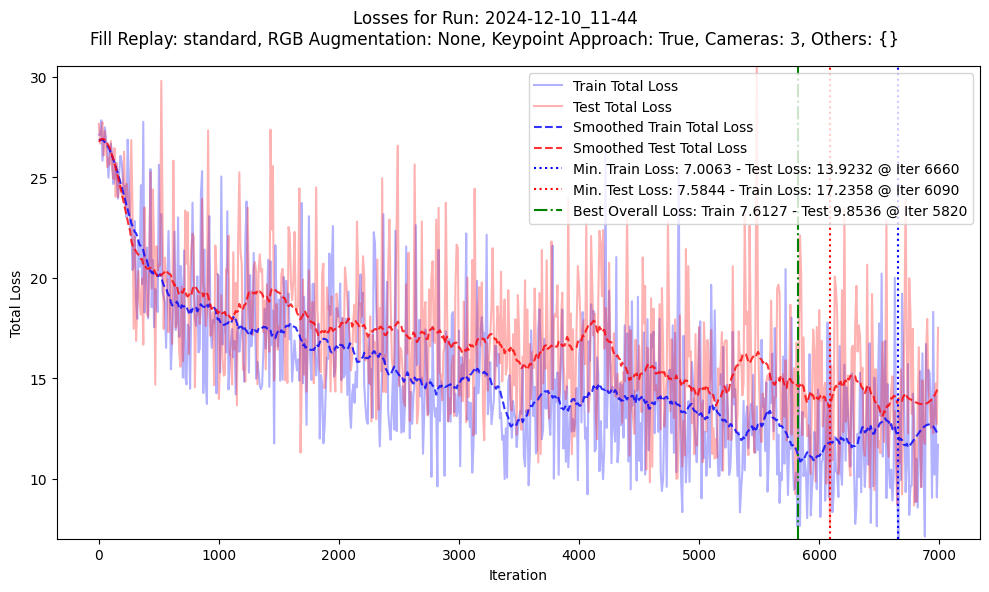

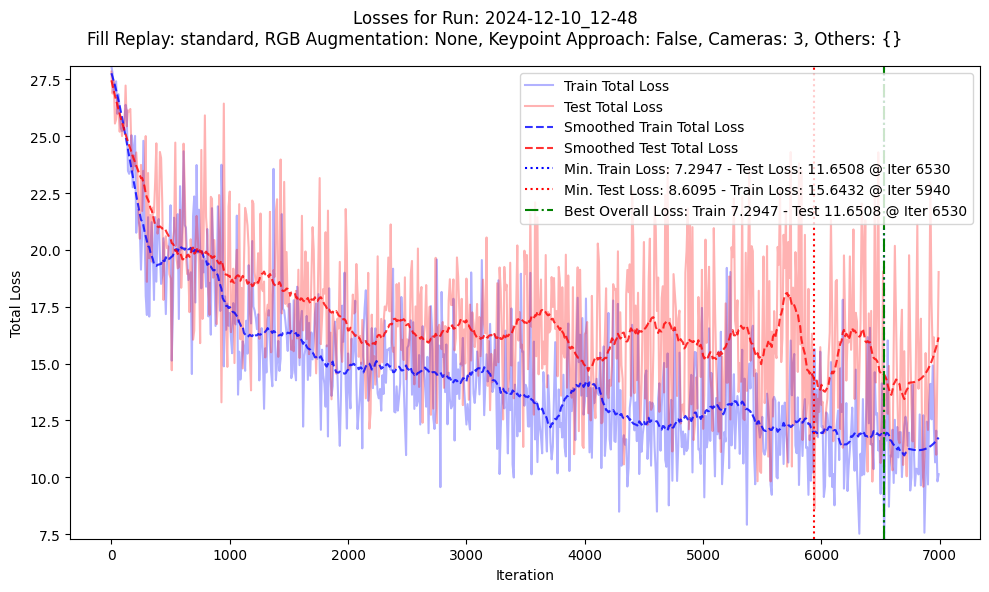

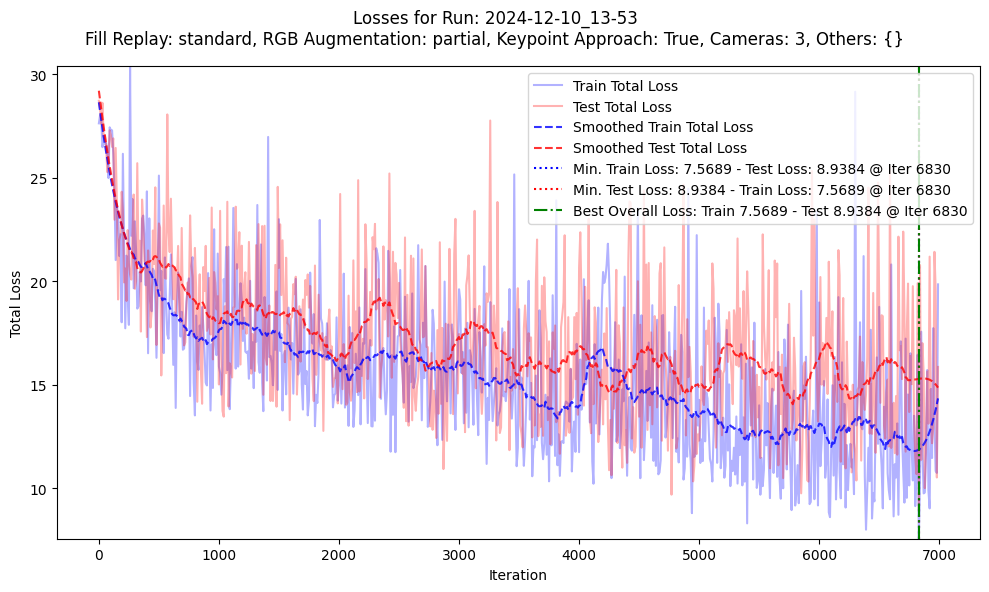

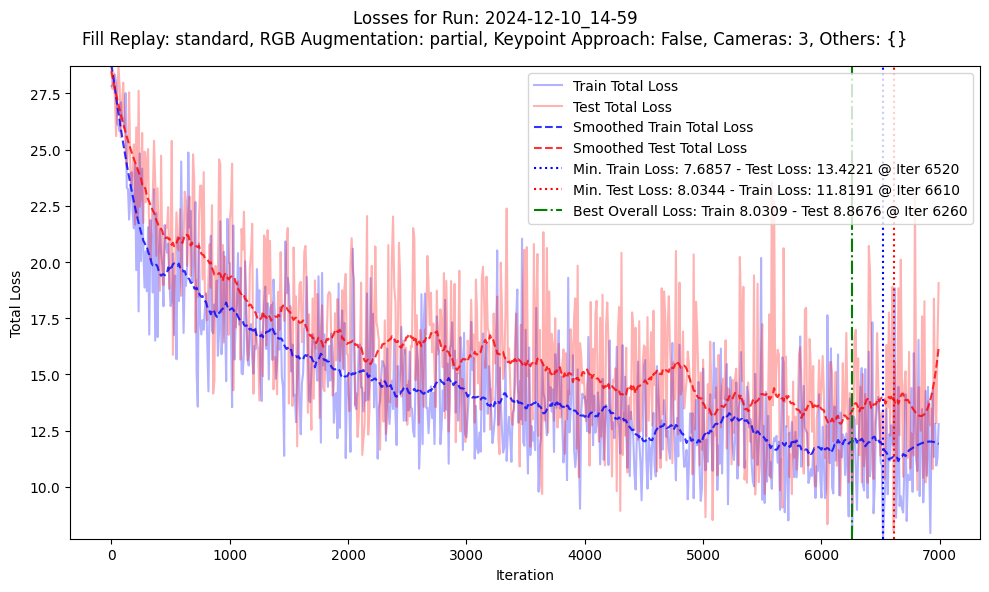

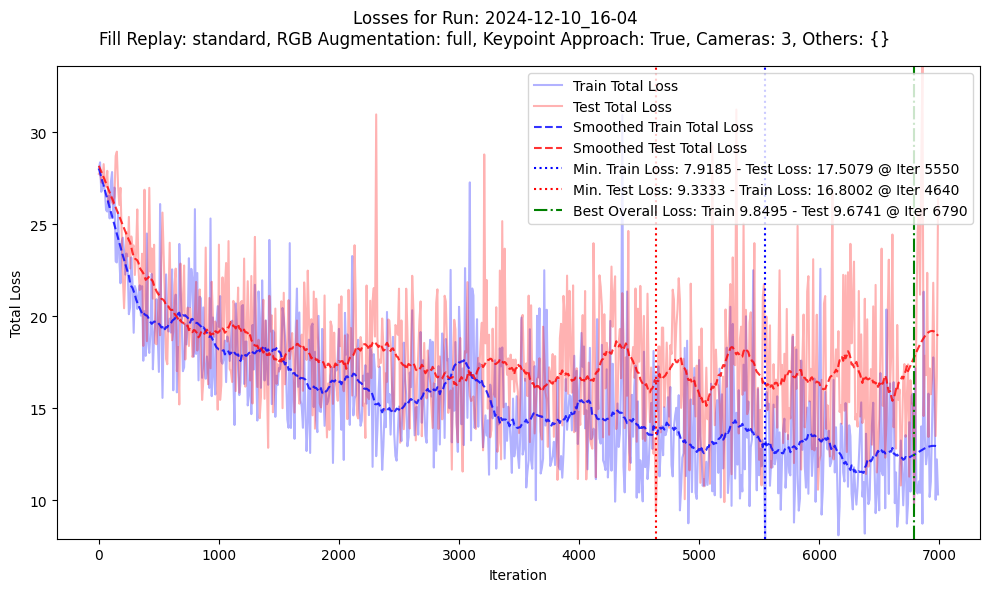

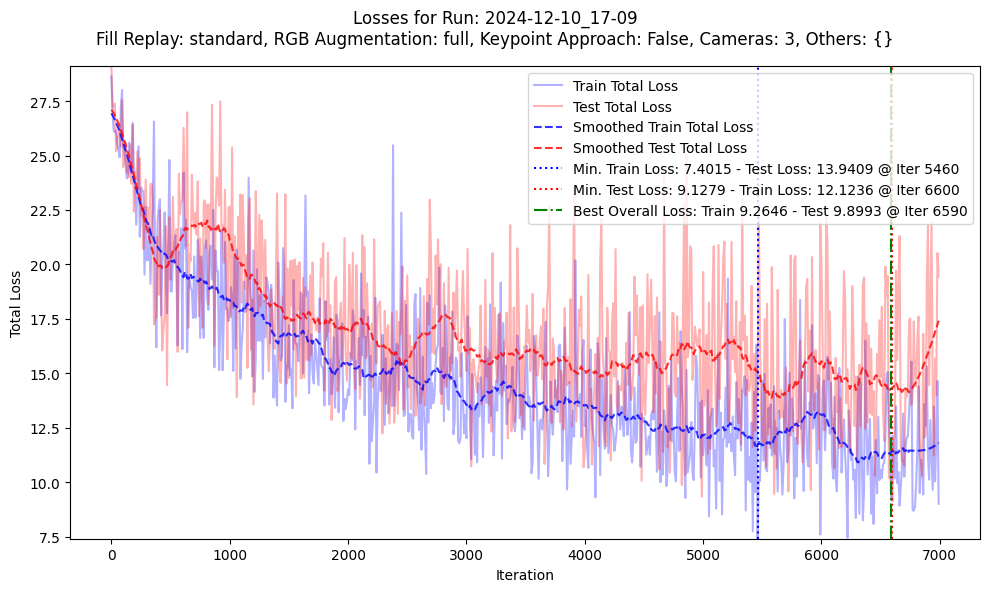

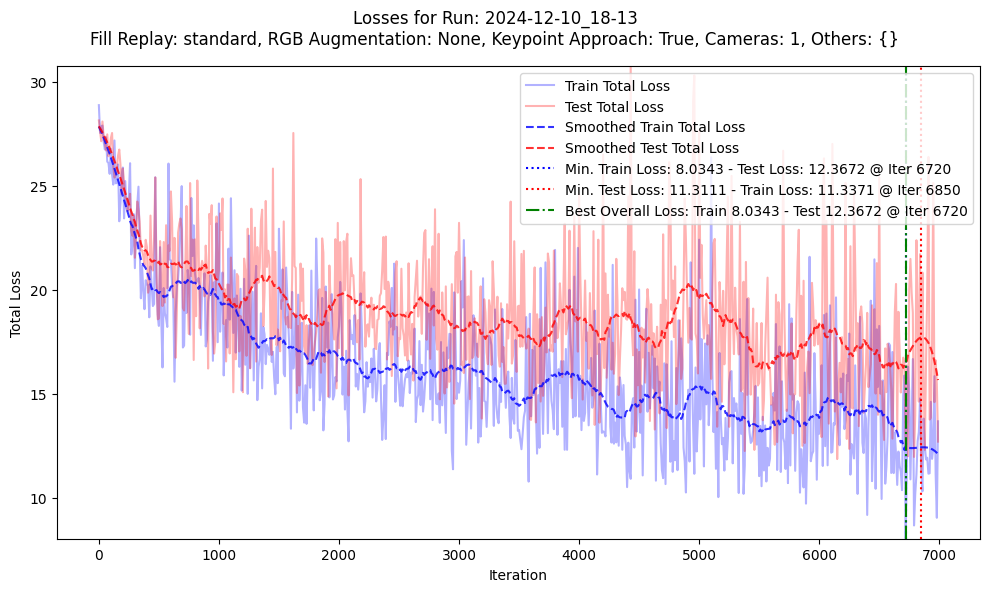

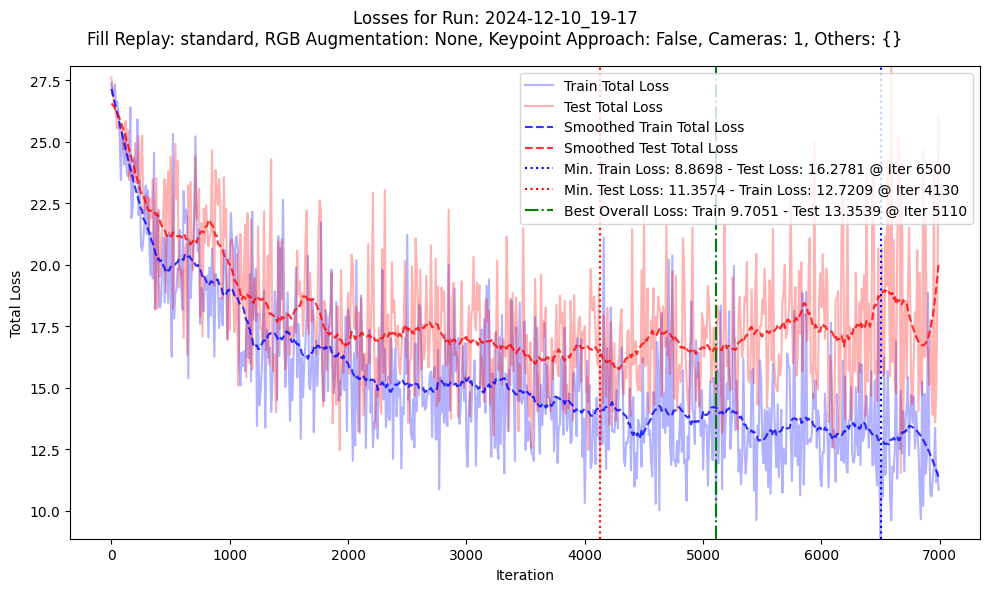

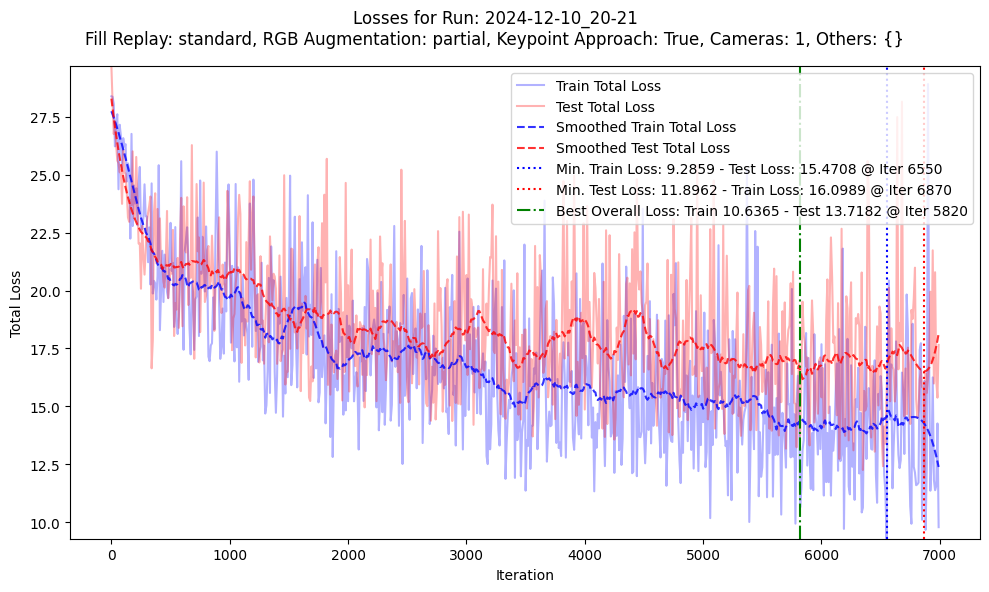

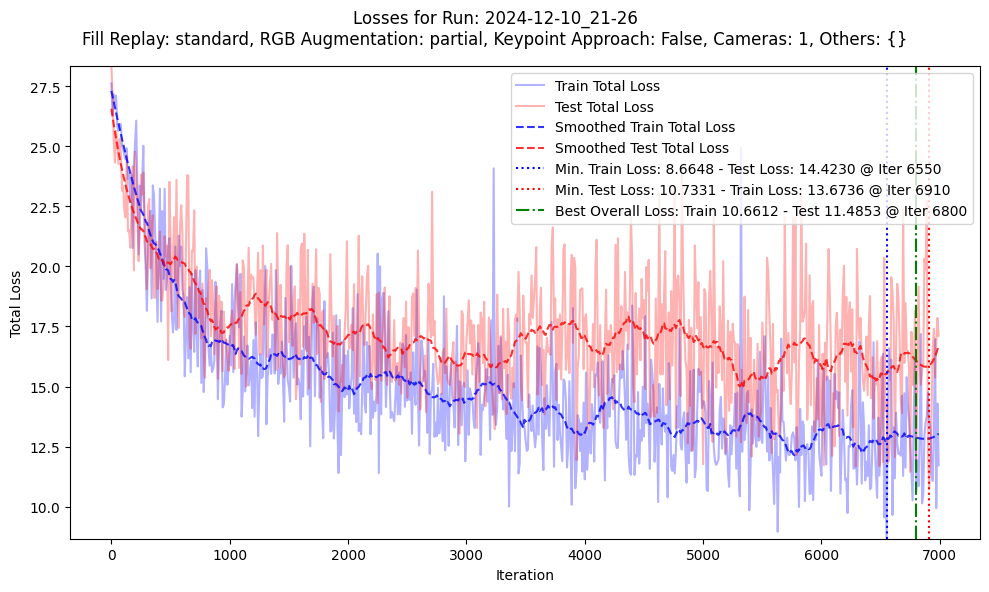

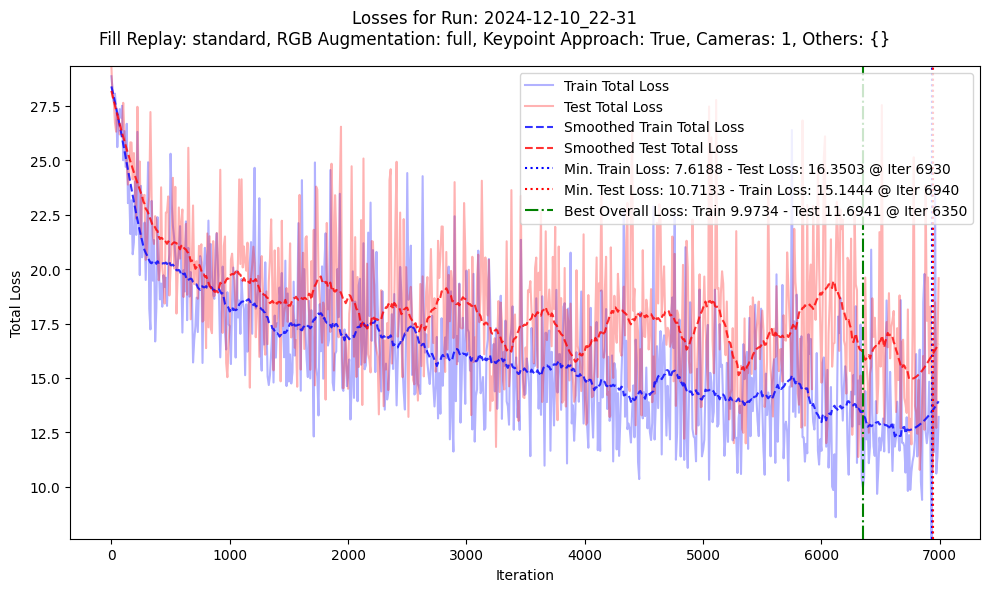

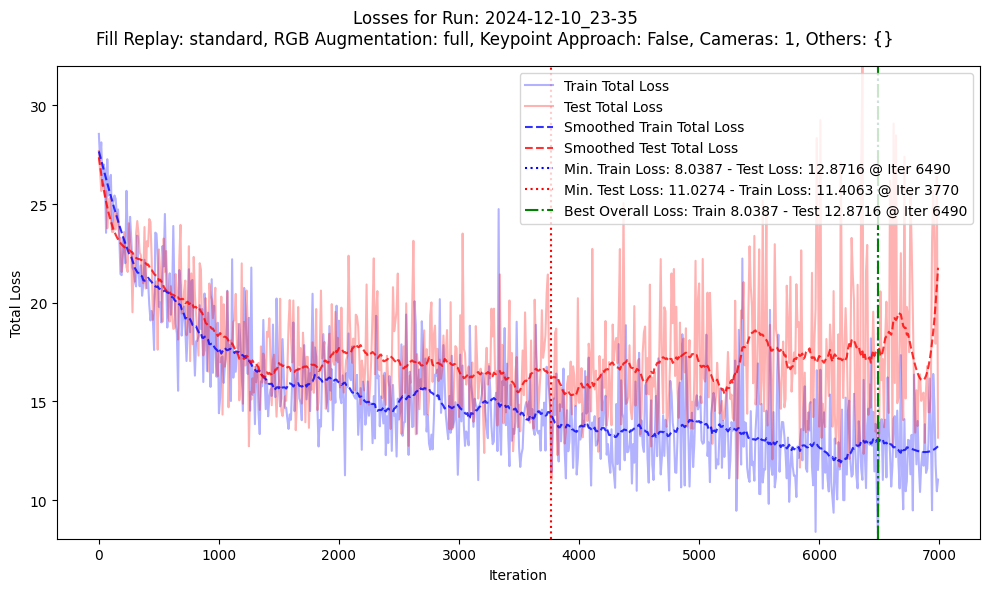

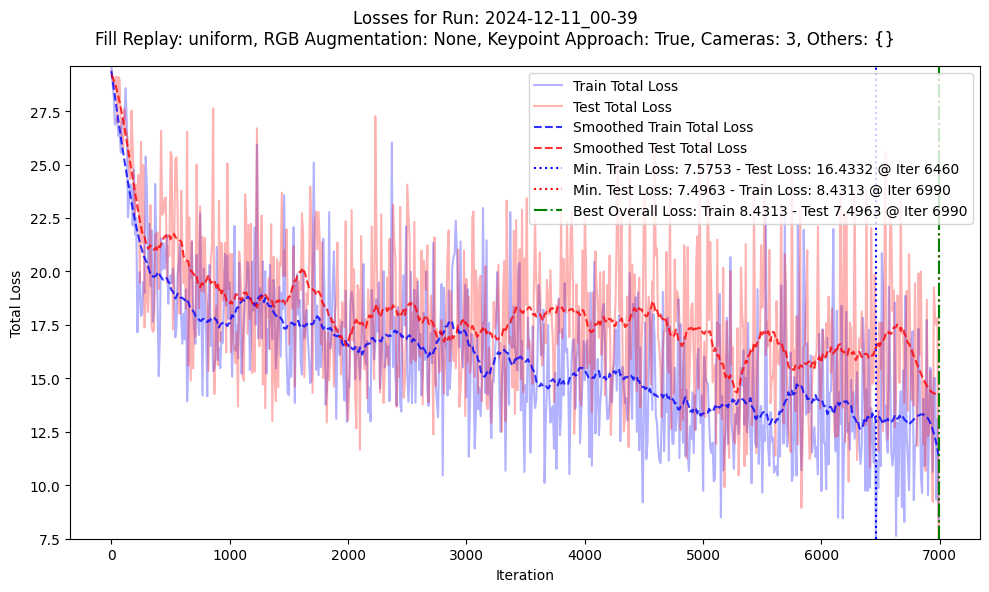

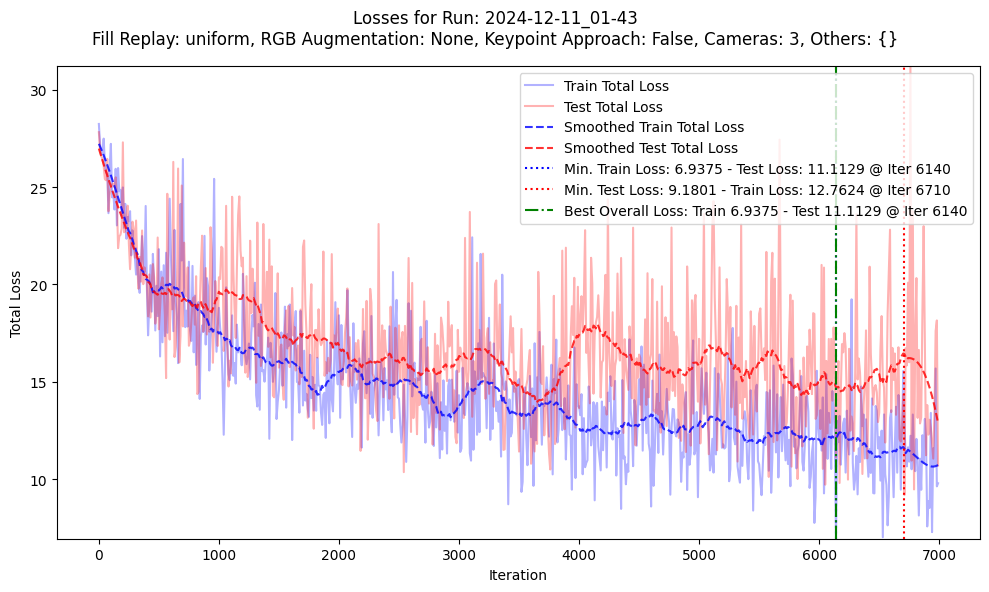

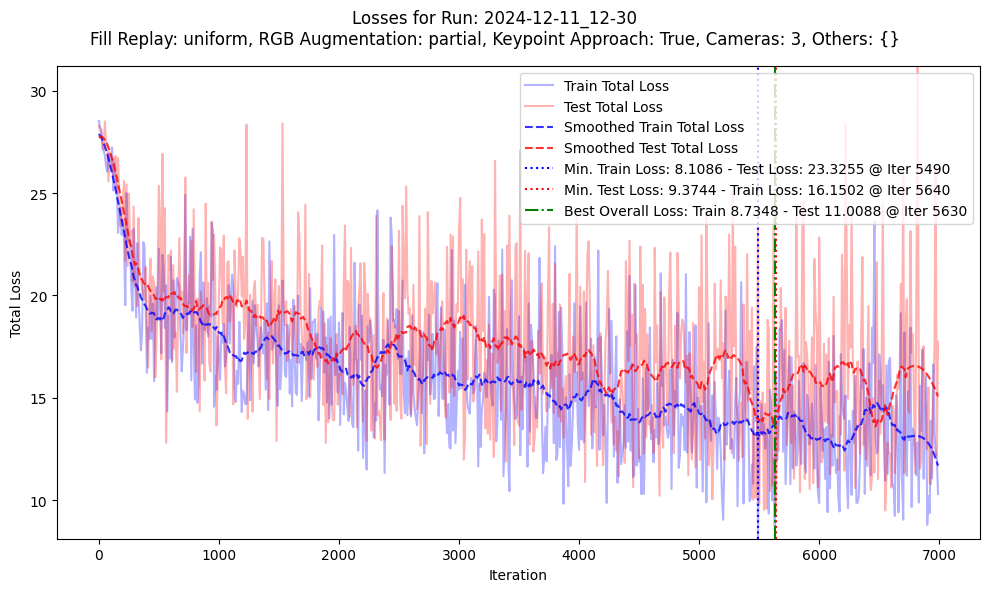

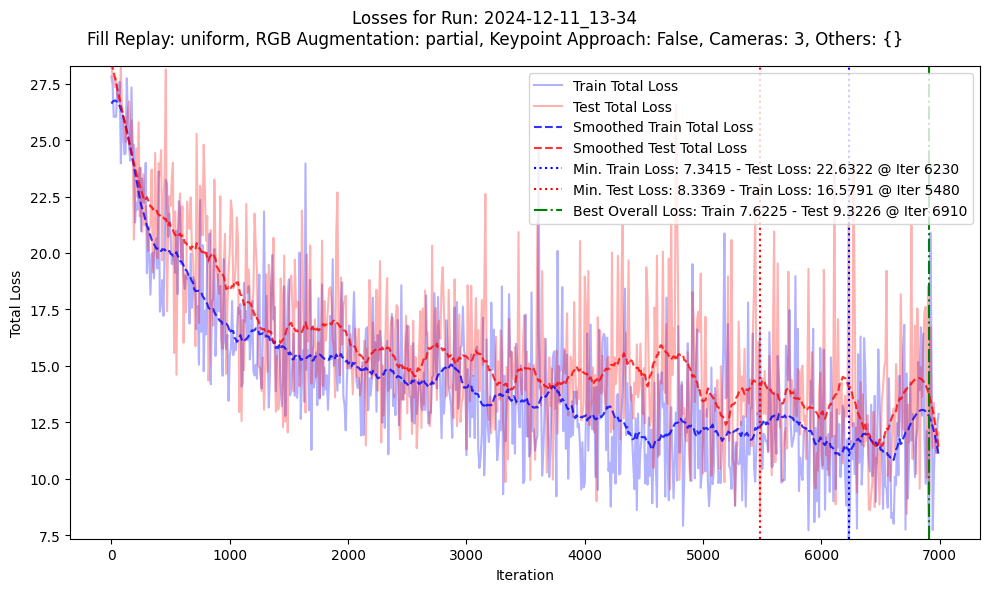

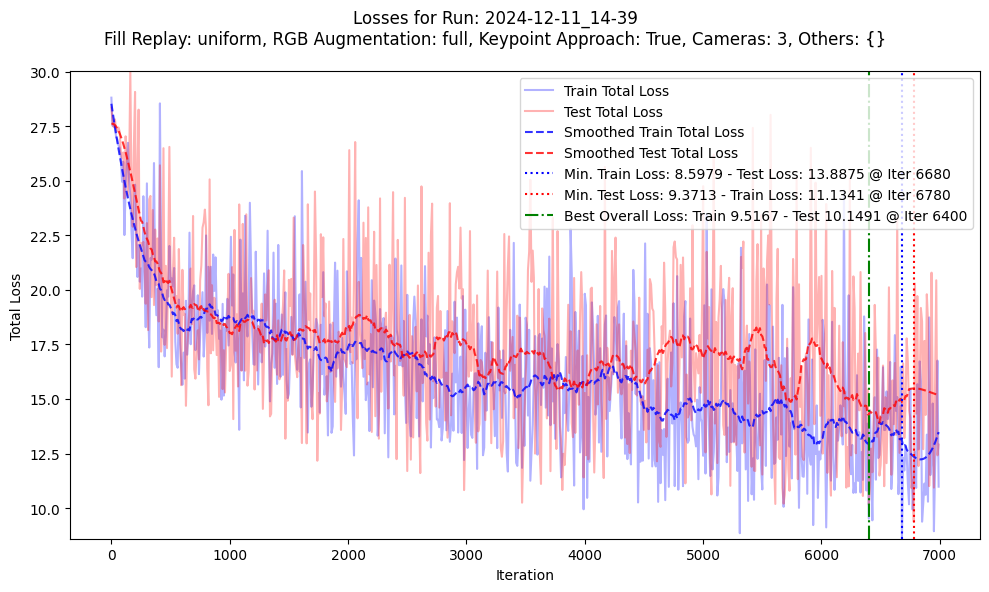

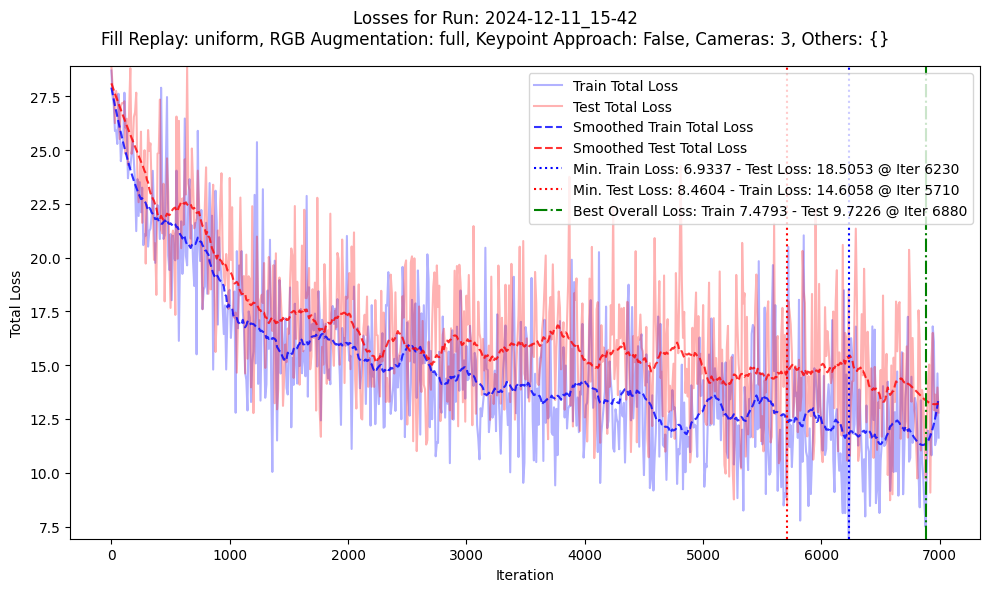

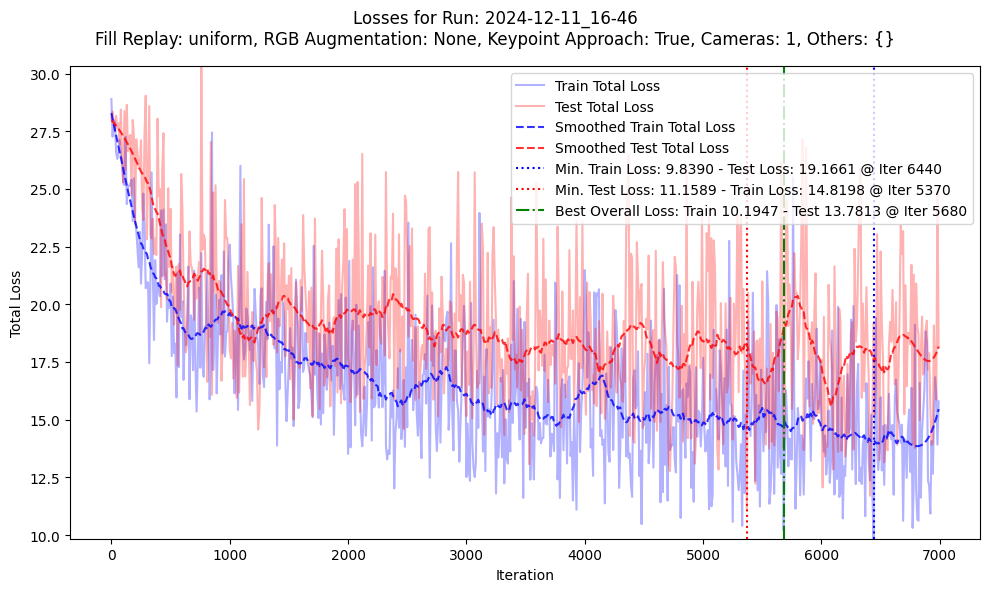

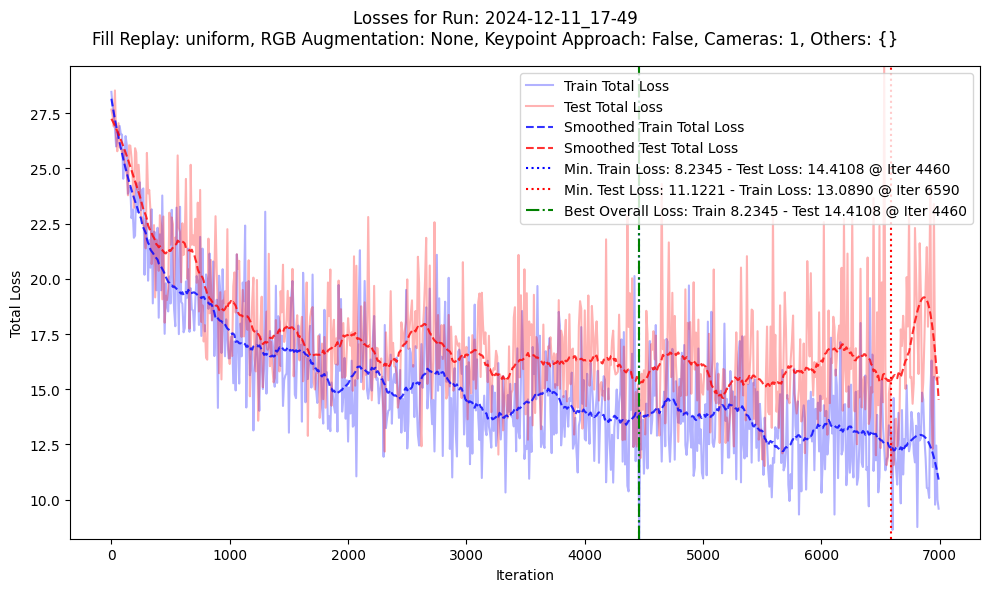

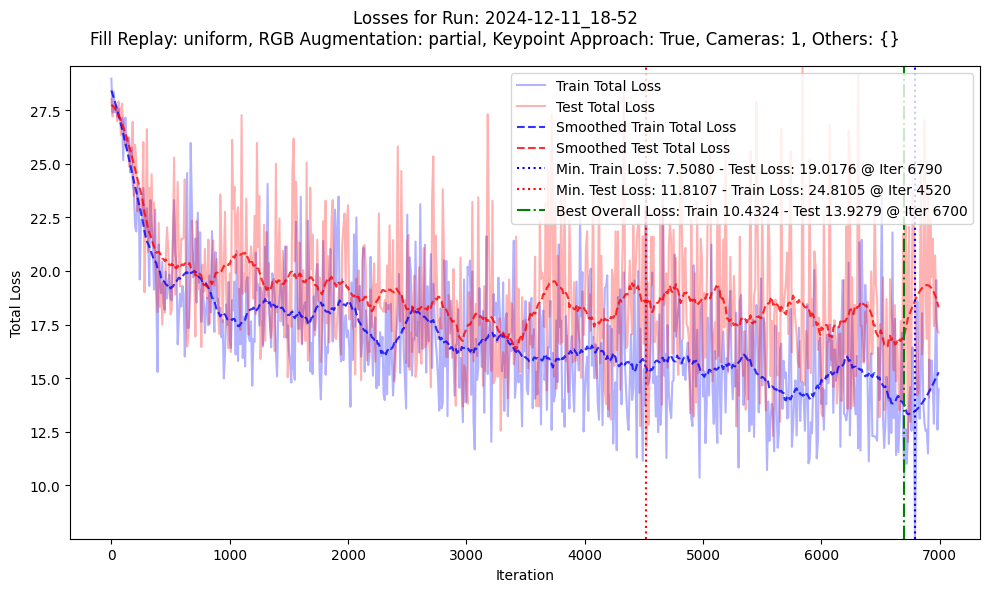

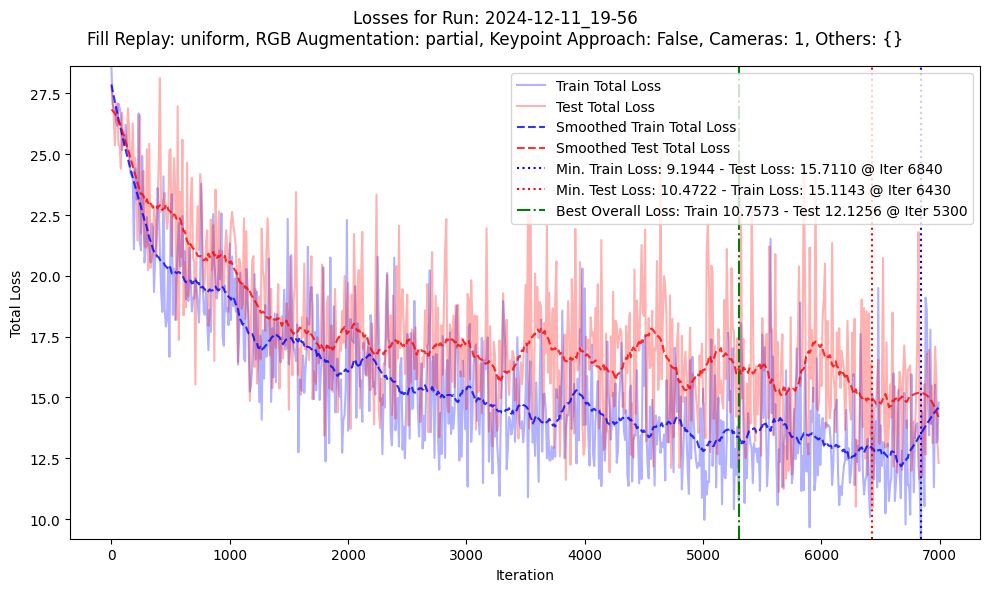

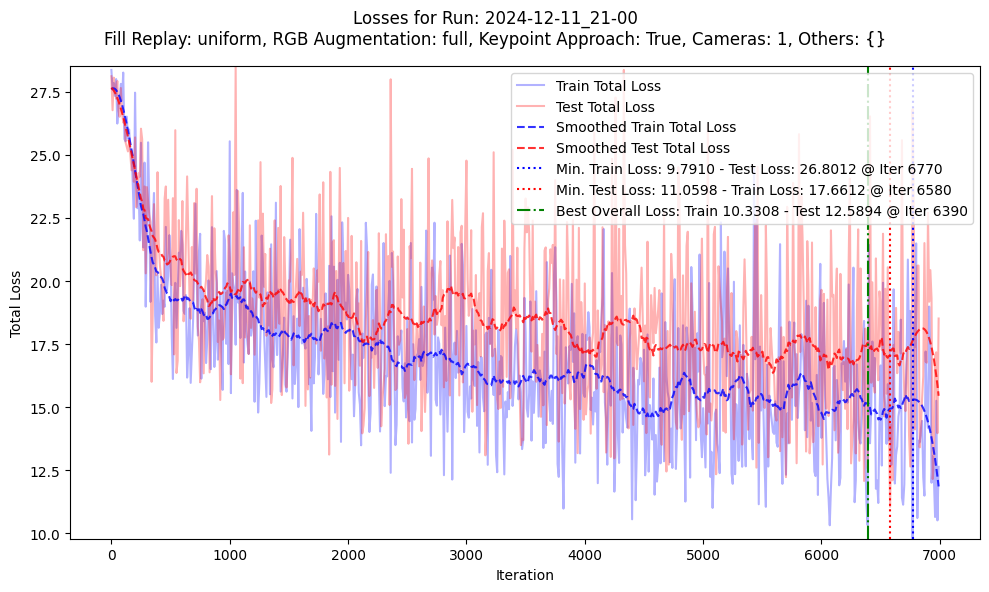

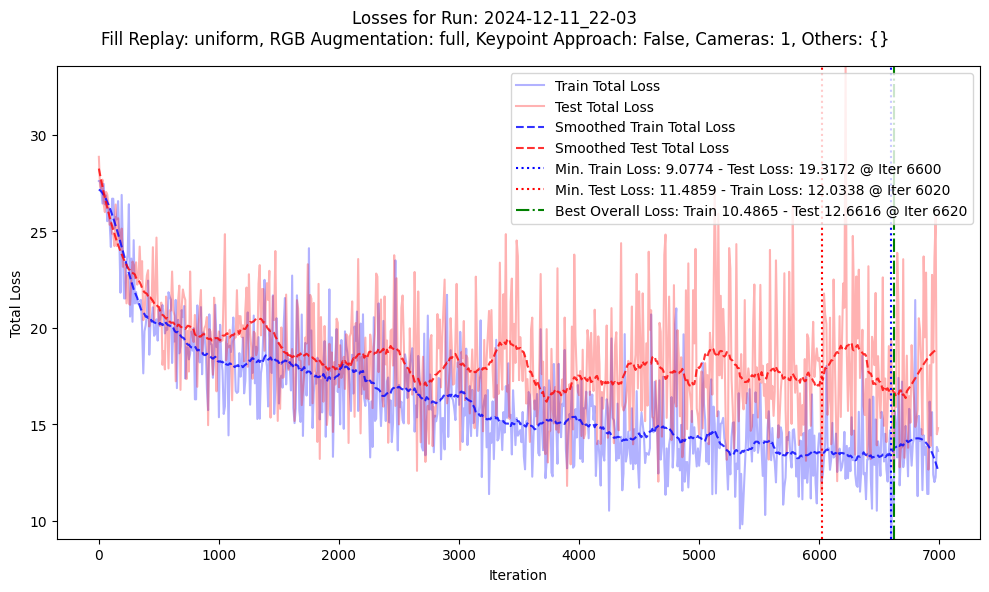

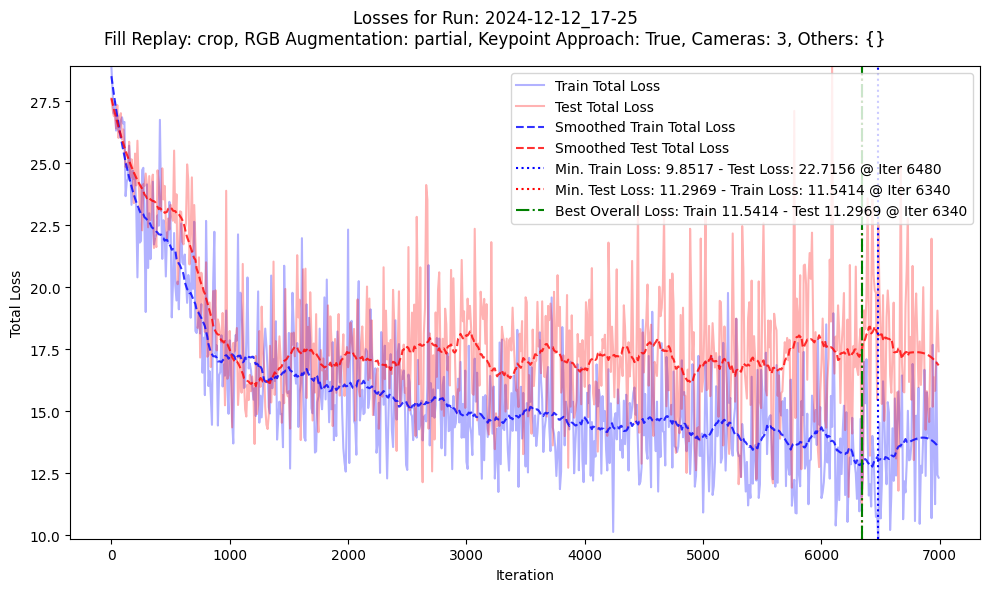

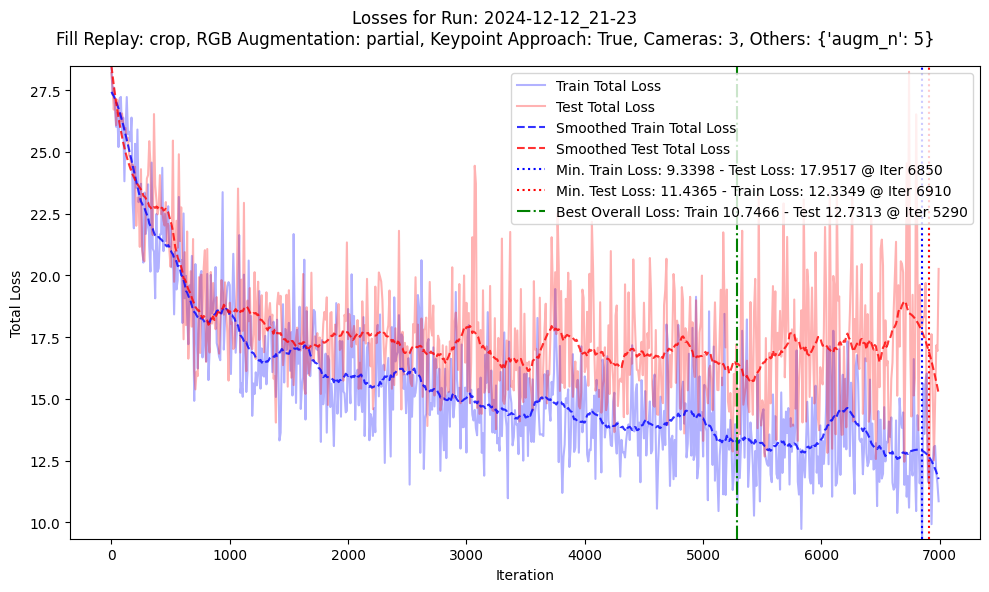

Fill Replay  Cameras RGB Augmentation  Keypoint Approach               Run  \
0     standard        3             None               True  2024-12-10_11-44   
1     standard        3             None              False  2024-12-10_12-48   
2     standard        3          partial               True  2024-12-10_13-53   
3     standard        3          partial              False  2024-12-10_14-59   
4     standard        3             full               True  2024-12-10_16-04   
5     standard        3             full              False  2024-12-10_17-09   
6     standard        1             None               True  2024-12-10_18-13   
7     standard        1             None              False  2024-12-10_19-17   
8     standard        1          partial               True  2024-12-10_20-21   
9     standard        1          partial              False  2024-12-10_21-26   
10    standard        1             full               True  2024-12-10_22-31   
11    standard        1             full              False  2024-12-10_23-35   
12     uniform        3             None               True  2024-12-11_00-39   
13     uniform        3             None              False  2024-12-11_01-43   
14     uniform        3          partial               True  2024-12-11_12-30   
15     uniform        3          partial              False  2024-12-11_13-34   
16     uniform        3             full               True  2024-12-11_14-39   
17     uniform        3             full              False  2024-12-11_15-42   
18     uniform        1             None               True  2024-12-11_16-46   
19     uniform        1             None              False  2024-12-11_17-49   
20     uniform        1          partial               True  2024-12-11_18-52   
21     uniform        1          partial              False  2024-12-11_19-56   
22     uniform        1             full               True  2024-12-11_21-00   
23     uniform        1             full              False  2024-12-11_22-03   
24        crop        3          partial               True  2024-12-12_17-25   
25        crop        3          partial               True  2024-12-12_21-23   

    Min Train Loss  Min Test Loss  Min Train Iteration  Min Test Iteration  \
0         7.006301       7.584447                 6660                6090   
1         7.294740       8.609462                 6530                5940   
2         7.568875       8.938406                 6830                6830   
3         7.685737       8.034409                 6520                6610   
4         7.918510       9.333313                 5550                4640   
5         7.401495       9.127899                 5460                6600   
6         8.034266      11.311061                 6720                6850   
7         8.869773      11.357412                 6500                4130   
8         9.285877      11.896225                 6550                6870   
9         8.664814      10.733100                 6550                6910   
10        7.618753      10.713268                 6930                6940   
11        8.038733      11.027428                 6490                3770   
12        7.575277       7.496336                 6460                6990   
13        6.937482       9.180121                 6140                6710   
14        8.108595       9.374382                 5490                5640   
15        7.341459       8.336948                 6230                5480   
16        8.597906       9.371294                 6680                6780   
17        6.933708       8.460373                 6230                5710   
18        9.838990      11.158878                 6440                5370   
19        8.234459      11.122110                 4460                6590   
20        7.508044      11.810707                 6790                4520   
21        9.194444      10.472160                 6840                6430   
22        9.791014   

In [18]:
metrics_dir = '/home/bepgroup/Projects/PerAct_ws/outputs/models/handing_over_banana/'
process_runs_with_settings(metrics_dir)